In [1]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
#from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

import warnings
import re
from collections import Counter
warnings.filterwarnings("ignore")

/opt/conda/envs/python3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(rc={'figure.figsize':(12,10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


In [3]:
def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))

In [4]:
dir_name = '../results/no_drug_embed_model/'

In [26]:
#每个癌症label数据数量（count）；和用药是否出现在CCL_dataset（top是出现多还是不出现多）
import pandas as pd
dataset = "gdsc1_raw"
Dataset_path = '../data/raw_dat/CCL_dataset/{}.csv'.format(dataset)
sensitivity_df = pd.read_csv(Dataset_path,index_col=1)
sensitivity_df.dropna(inplace=True,subset=['cid'])

tcga = pd.read_csv('../data/tcga/PDR_data/tcga918_single_drug_response_df.csv',index_col=0)
tcga['isin'] = tcga['cid'].isin(sensitivity_df['cid'].drop_duplicates().values)
tcga.groupby('tcga_project')['isin'].describe()  #  ESCA   MESO

,count,unique,top,freq
tcga_project,,,,
ACC,3,2,False,2
BLCA,9,1,False,9
BRCA,28,2,False,25
CESC,24,2,False,22
CHOL,3,1,False,3
COAD,10,2,False,6
ESCA,6,2,False,4
GBM,254,2,True,180
HNSC,46,2,False,44


In [30]:
#查看每个癌种有多少个unlabelled数据------

#9808个xena中有gex的样本
xena_sample_with_gex = pd.read_csv("../data/preprocessed_dat/xena_sample_with_gex.csv")
#10593个有sample_info的样本
sample_info = pd.read_csv("../data/tcga/sample_info.csv")

match_sample = xena_sample_with_gex.merge(sample_info,left_on="Sample",right_on="sample")
match_sample['tumor_type'].value_counts()


BRCA    1092
KIRC     530
HNSC     518
LUAD     513
LGG      509
THCA     504
LUSC     498
PRAD     495
OV       419
STAD     414
BLCA     407
LIHC     369
CESC     304
KIRP     288
COAD     288
SARC     258
ESCA     181
UCEC     180
PAAD     178
PCPG     177
GBM      153
TGCT     148
THYM     119
SKCM     102
READ      92
MESO      87
UVM       79
ACC       77
KICH      66
UCS       57
DLBC      47
CHOL      36
Name: tumor_type, dtype: int64

## Chemotherapy Drug Response Prediction

In [5]:
def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, pds,sgm,zds,cds,sdm,folder,measurement='AUC',metric_name='auroc',pdtc_flag=False):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/'
    else:
        folder = f'{folder}/{method}/{pds}/{sgm}/{zds}/{cds}/{sdm}/{measurement}/'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]

In [7]:
#已经在一组参数内求完均值了，正常有预训练和训练的共3*10*2=60组
def parse_hyper_ft_evaluation_result(method,pds,sgm,zds,cds,sdm,folder, measurement='AUC',metric_name='auroc', pdtc_flag = False):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc'
    else:
        folder = f'{folder}/{method}/{pds}/{sgm}/{zds}/{cds}/{sdm}/{measurement}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    to_exclude = []
    for k, v in evaluation_metrics_count.items():
        if v < 0.6: 
            to_exclude.append(k)
            
    if len(to_exclude)>0:
        for k in to_exclude:
            evaluation_metrics.pop(k)
            evaluation_metrics_std.pop(k)
                    
    return evaluation_metrics, evaluation_metrics_std, count
            

In [8]:
#新写一个函数，得到adv中最好的order
def generate_best_params(folder,sgm = "Percent_sd",cds = "gdsc1_raw",sdm = "overlap",method = "code_adv_norm",metric_name='auroc', measurement='AUC', pdtc_flag=False):
    # methods = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution']
    Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", "kirp", 
          "luad", "lusc", "paad", "prad", "read", "sarc", "skcm"]
    Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc",  "kirc", "kirp", 
          "luad", "lusc", "paad", "prad",  "sarc"] #unlabel data > 100
#     Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", "kirp", 
#          "lgg", "lihc", "luad", "lusc", "ov", "paad", "prad", "read", "sarc", "skcm", "stad"]
    ZDS = [element.upper() for element in Tumor_type_list]

    report = pd.DataFrame(np.zeros((2, len(ZDS))),index=[["match","tcga"]],columns=ZDS)
    report_std = pd.DataFrame(np.zeros((2, len(ZDS))), index=[["match","tcga"]],columns=ZDS)
    result_dict = defaultdict(dict)

    for zds in ZDS:
        # print(f'{method}: {cat}')
        folder = f'{folder}/{method}'
        try:
            pds = zds.lower()
            param_str, report.loc["match",zds], report_std.loc["match",zds] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method,pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[0],
                                                                                    std_dict = parse_hyper_ft_evaluation_result(method=method, pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[1])
            
            print(pds,"to",zds,param_str," : ",
                 report.loc["match",zds].values, report_std.loc["match",zds].values
                 )
            result_dict[zds]["match"] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm,
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag,
                                                                          folder=dir_name)
        except Exception as e:
                print(e)

        try:
            pds = "tcga"
            param_str, report.loc[pds,zds], report_std.loc[pds,zds] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method,pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[0],
                                                                                    std_dict = parse_hyper_ft_evaluation_result(method=method, pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[1])
            
            print(pds,"to",zds,param_str," : ",
                 report.loc[pds,zds].values, report_std.loc[pds,zds].values
                 )
            result_dict[zds]["tcga"] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm,
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag,
                                                                          folder=dir_name)
          
        except Exception as e:
                print(e)
                
    return report, report_std, result_dict


In [10]:
#得到最好的参数
dir_name = '../results/no_drug_embed_model/'
# dir_name = '../results/test_fenlei_for_com/'
select_method = ['code_adv', 'dsn', 'dsna','code_base', 'code_mmd', 'adae', 'coral', 'dae', 'vae', 'ae'][1] + "_norm"

auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(
        sdm = "overlap",method = select_method,pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')
#



brca to BRCA train_num_epochs_2500_dop_0.0_ft_evaluation_results.json  :  [0.51122449] [0.03312792]
tcga to BRCA train_num_epochs_300_dop_0.1_ft_evaluation_results.json  :  [0.46122449] [0.02081232]
cesc to CESC train_num_epochs_2500_dop_0.1_ft_evaluation_results.json  :  [0.64444444] [0.06416005]
tcga to CESC train_num_epochs_1500_dop_0.0_ft_evaluation_results.json  :  [0.68888889] [0.07019044]
coad to COAD train_num_epochs_300_dop_0.0_ft_evaluation_results.json  :  [0.8125] [0.19364917]
tcga to COAD train_num_epochs_2000_dop_0.1_ft_evaluation_results.json  :  [0.8] [0.19921722]
gbm to GBM train_num_epochs_2000_dop_0.1_ft_evaluation_results.json  :  [0.62560484] [0.05507982]
tcga to GBM train_num_epochs_1000_dop_0.0_ft_evaluation_results.json  :  [0.53983193] [0.02001059]
hnsc to HNSC train_num_epochs_100_dop_0.1_ft_evaluation_results.json  :  [0.50632411] [0.03986808]
tcga to HNSC train_num_epochs_200_dop_0.0_ft_evaluation_results.json  :  [0.49209486] [0.03452564]
kirc to KIRC train

In [11]:
increase = auc_ft_report.pct_change(periods=-1,axis=0).iloc[0,:]
a = auc_ft_report.append(increase*100)
a.index = ['match','tcga','increase%']
# a.to_csv("../results/no_drug_embed_model/code_adv_norm/random_12_result.csv")
a

,BRCA,CESC,COAD,GBM,HNSC,KIRC,KIRP,LUAD,LUSC,PAAD,PRAD,SARC
match,0.511224,0.644444,0.8125,0.625605,0.506324,0.467391,5.722222e-01,0.528788,0.658000,0.455820,0.683333,0.601778
tcga,0.461224,0.688889,0.8000,0.539832,0.492095,0.426449,5.722222e-01,0.574242,0.642000,0.462169,0.811538,0.655111
increase%,10.840708,-6.451613,1.5625,15.888817,2.891566,9.600680,2.220446e-14,-7.915567,2.492212,-1.373784,-15.797788,-8.141113


In [15]:
method = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution'][16]
cat = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu'][1]
a = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name="auroc", measurement="AUC", pdtc_flag=False) #已经在一组参数内求完均值了，正常有预训练和训练的共3*10*2=60组
aa = get_largest_kv(d = a[0],
                std_dict = a[1]) #拿到均值最大的一组,另一个是方差
aa

('pretrain_num_epochs_0_train_num_epochs_1000_dop_0.0_ft_evaluation_results.json',
 0.6980571428571429,
 0.013443031728029829)

In [35]:
#average rank when predict chemotherapy prediction on relapses after treatment
auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

match    1.083333
tcga     1.916667
dtype: float64

In [15]:
#  pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm,
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc",  "kirc", "kirp", 
          "luad", "lusc", "paad", "prad",  "sarc"] #unlabel data > 100
ZDS = [element.upper() for element in Tumor_type_list]

# drug_mapping = pd.read_csv('../data/tcga_gdsc_drug_mapping.csv', index_col=0)

# drug_dict = drug_mapping['gdsc_name'].to_dict()
# drug_dict['tgem'] = 'Gemcitabine (diagnosis)'
# drug_dict['tfu'] = '5-Fluorouracil (diagnosis)'

result_df = None
for cat in ZDS:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])
    # temp_df = temp_df.rename(columns={'tcrp': 'TCRP',"dae_norm": "dae",'cell_enet':'CELLIGNER','dsn_norm':"dsn-mmd", 'dsna_norm': 'dsn-dann', 'code_adv_norm': 'code-ae-adv'})
    # temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['Tumor_type'] = cat
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
# method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE',"VELODROME", 'CODE-AE-ADV',"DECONVOLUTION"]
# result_df.method = result_df.method.astype('category')
# result_df.method.cat.set_categories(method_order, inplace=True)
# result_df.sort_values(by='method', inplace=True)

# drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
# result_df.Tumor_type = result_df.drug.astype('category')
# result_df.Tumor_type.cat.set_categories(drug_order, inplace=True)
# result_df.sort_values(by='Tumor_type', inplace=True)



In [13]:
palette ={
    'match':'mediumpurple', 
    # 'RF':'rebeccapurple',
    # 'MLP':'purple', 
    # 'AE':'palegreen',
    # 'DAE':'limegreen',
    # 'VAE':'seagreen',
    # 'VAEN': 'darkgreen',
    # 'CORAL':'orange',
    # 'ADAE':'blue', 
    # 'COXEN':'lightgray',
    # 'COXRF':'darkgray',
    # 'CELLIGNER':'darkslategray',
    # 'DSN-MMD':'gold',
    # 'DSN-DANN':'yellow', 
    # 'TCRP':'black',
    # "VELODROME":"pink",
    # 'CODE-AE-ADV':'red',
    "tcga":'grey'}

# marker_dict = {
#     'ENET':'s', 
#     'RF':'s',
#     'MLP':'s', 
#     'AE':'P',
#     'DAE':'P',
#     'VAE':'P',
#     'VAEN': 'P',
#     'CORAL':'H',
#     'ADAE':'H', 
#     'COXEN':'X',
#     'COXRF':'X',
#     'CELLIGNER':'X',
#     "VELODROME":"H",
#     'DSN-MMD':'D',
#     'DSN-DANN':'D', 
#     'TCRP':'s',
#     'CODE-AE-ADV':'o'
# }

<Figure size 1000x1200 with 0 Axes>

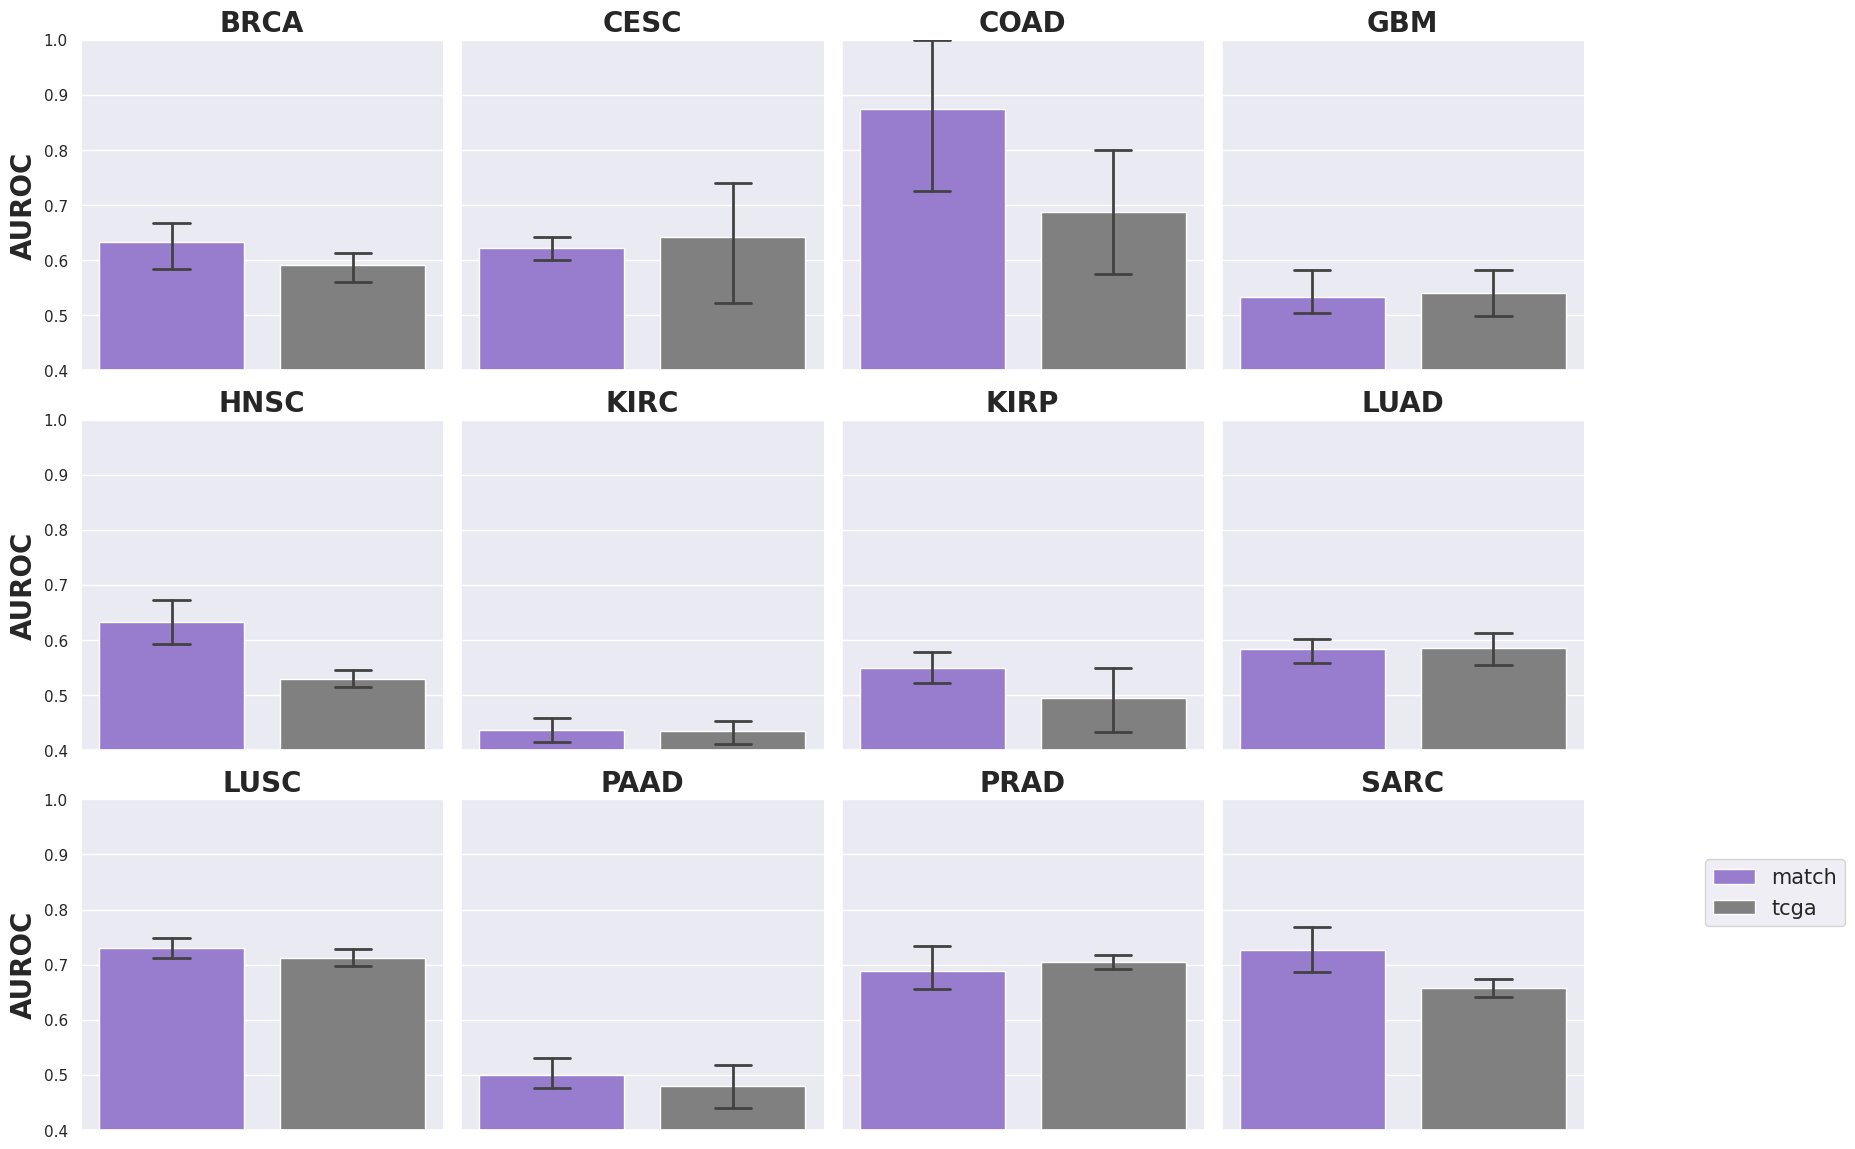

In [16]:
plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="Tumor_type", col_wrap=4, height=4)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.4,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=15)
plt.show()
#plt.savefig('../paper/tcga_auc_bar.png', format='png', dpi=350,bbox_inches='tight')

### AUPRC

In [62]:
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(method = "code_adv_norm",pdtc_flag=False, folder=dir_name,metric_name='auprc', measurement='AUPRC')

[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/brca/Percent_sd/BRCA/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/tcga/Percent_sd/BRCA/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/cesc/Percent_sd/CESC/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/tcga/Percent_sd/CESC/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/coad/Percent_sd/COAD/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/tcga/Percent_sd/COAD/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/gbm/Percent_sd/GBM/gdsc1_raw/overlap/AUPRC'
[Errno 2] No such file or directory: '../results/no_drug_embed_model//code_adv_norm/tcga/Per

In [36]:
result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auprc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP','cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'code_adv_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUPRC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auprc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE',"VELODROME", 'CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)

<Figure size 1080x720 with 0 Axes>

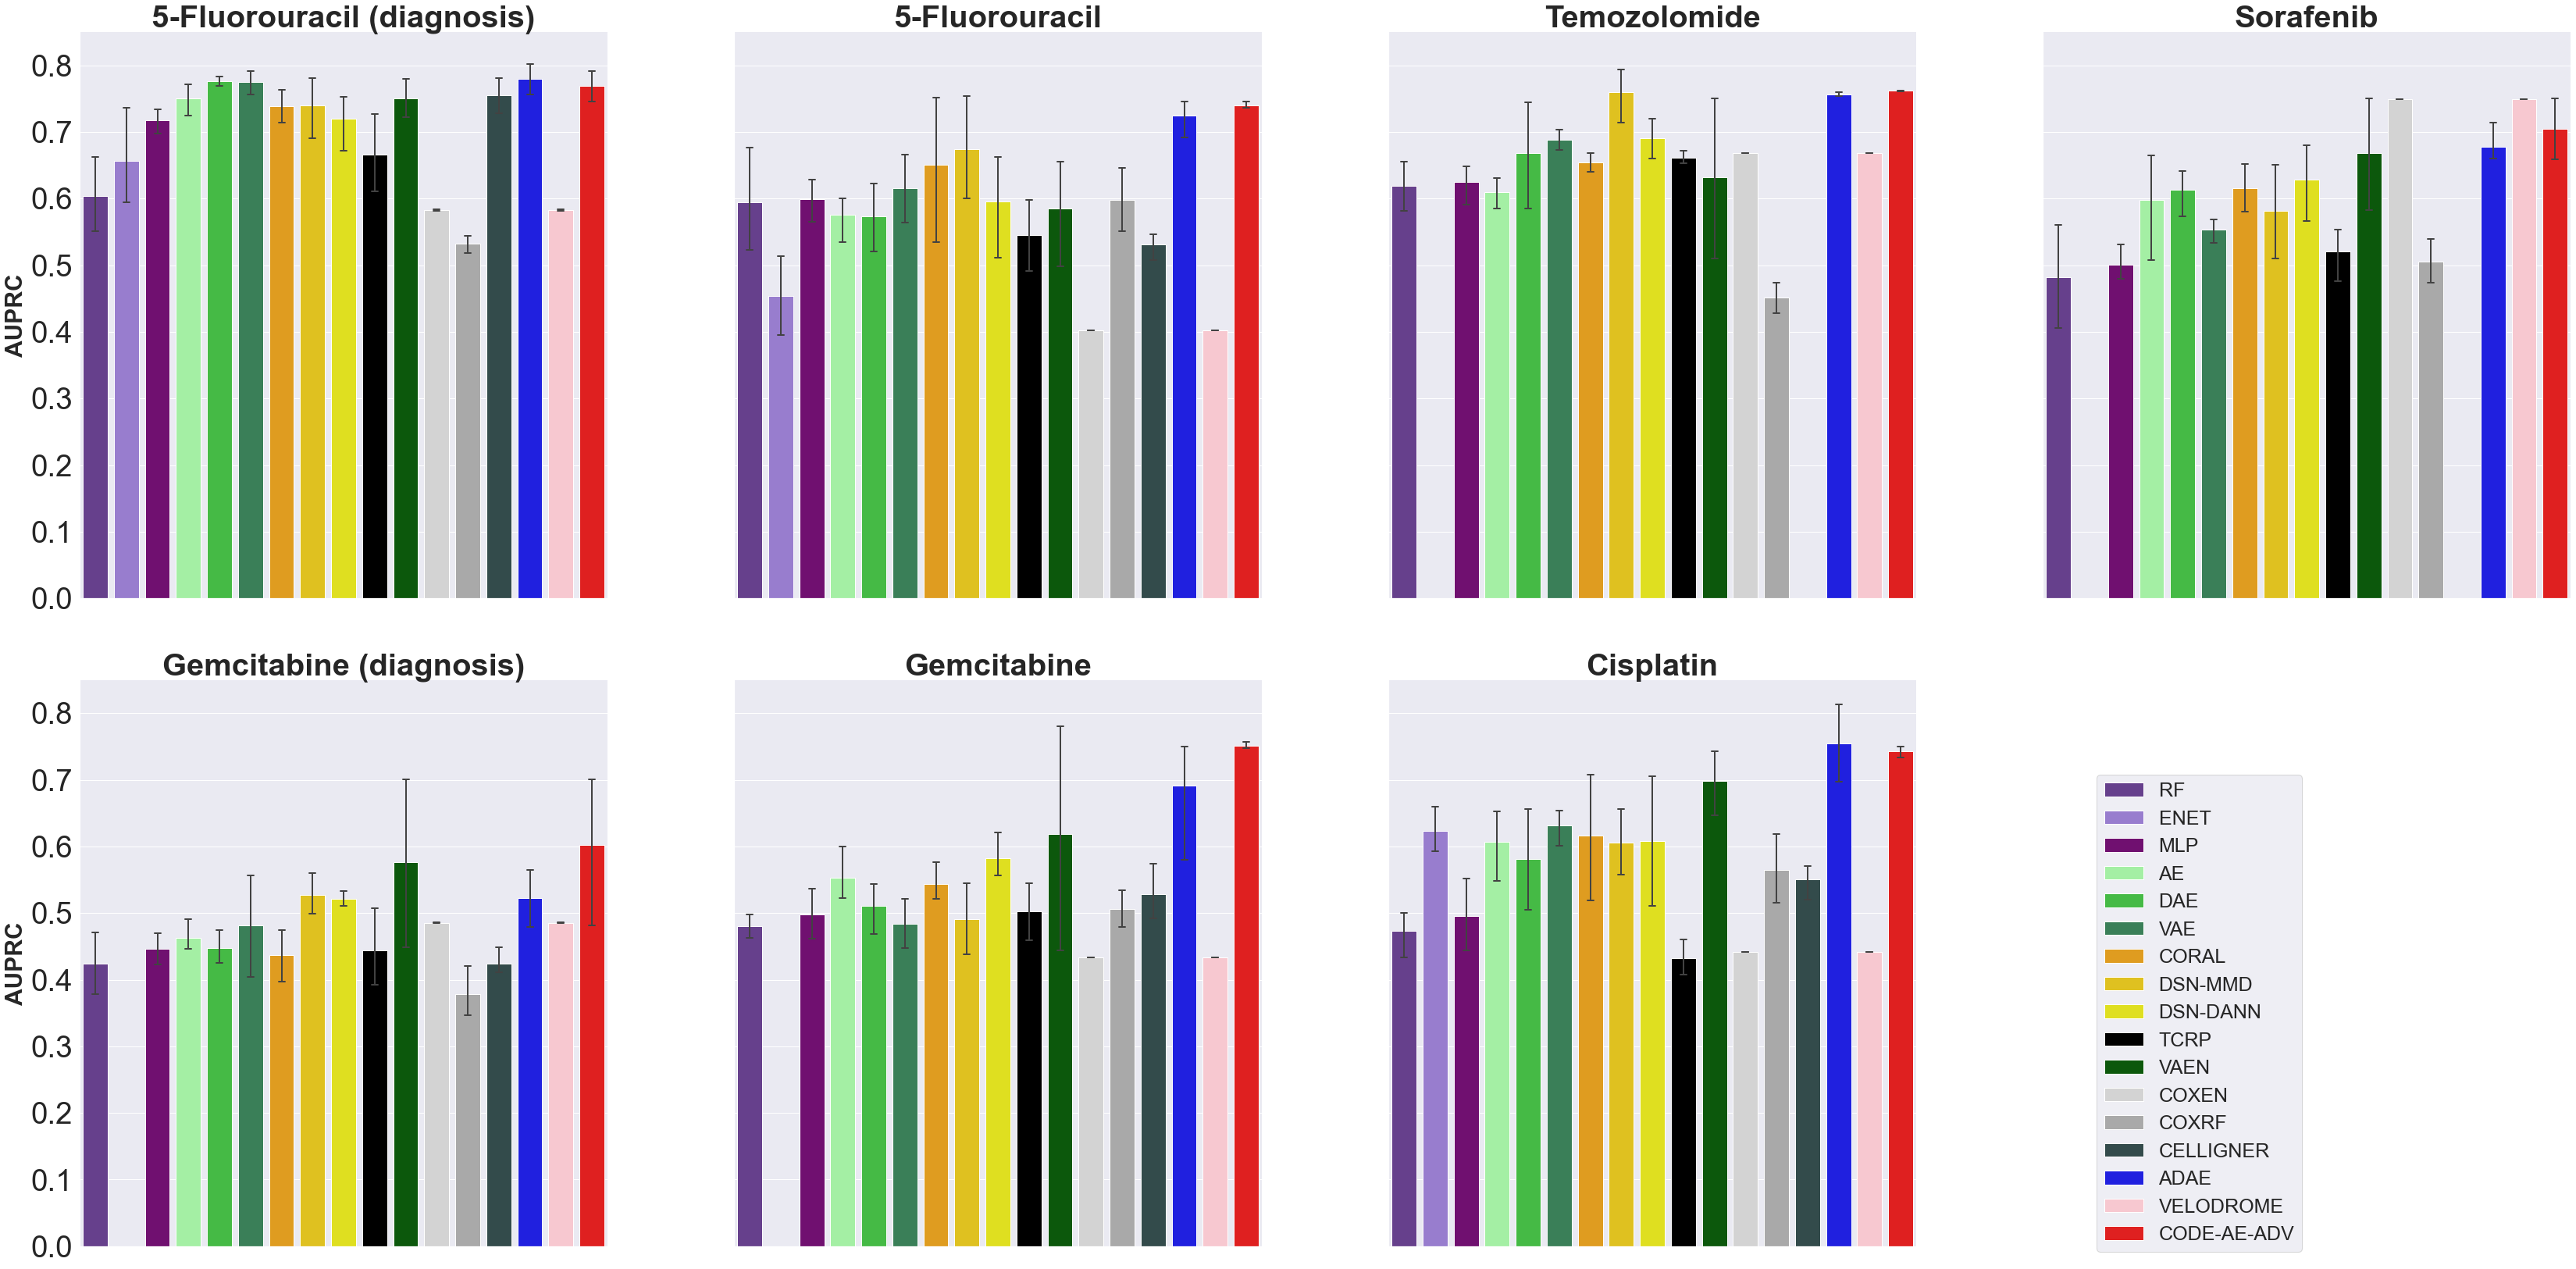

In [37]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUPRC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auprc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.0,0.85))
g.set_xlabels('')
g.set_ylabels('AUPRC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auprc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [39]:
## check p vals
print('Gemcitabine (diagnosis): rank 1')
generate_p_val(a=auc_ft_result_dict['tgem']['code_adv_norm'], b=auc_ft_result_dict['tgem']['vaen'])
print('5-Fluorouracil (diagnosis): rank 2')
generate_p_val(a=auc_ft_result_dict['tfu']['code_adv_norm'], b=auc_ft_result_dict['tfu']['adae'])
print('5-Fluorouracil: rank 1')
generate_p_val(a=auc_ft_result_dict['fu']['code_adv_norm'], b=auc_ft_result_dict['fu']['adae'])
print('Temozolomide: rank 1')
generate_p_val(a=auc_ft_result_dict['tem']['code_adv_norm'], b=auc_ft_result_dict['tem']['adae'])
print('Sorafenib: rank 3')
generate_p_val(a=auc_ft_result_dict['sor']['code_adv_norm'], b=auc_ft_result_dict['sor']['velodrome'])
print('Gemcitabine: rank 1')
generate_p_val(a=auc_ft_result_dict['gem']['code_adv_norm'], b=auc_ft_result_dict['gem']['adae'])
print('Cisplatin: rank 2')
generate_p_val(a=auc_ft_result_dict['cis']['code_adv_norm'], b=auc_ft_result_dict['cis']['adae'])

Gemcitabine (diagnosis): rank 1
ttest_ind:            t = 8.57459  p = 0.000379119
5-Fluorouracil (diagnosis): rank 2
ttest_ind:            t = 0.699231  p = 0.518632
5-Fluorouracil: rank 1
ttest_ind:            t = 8.42216  p = 4.69713e-05
Temozolomide: rank 1
ttest_ind:            t = 4.94461  p = 0.0020183
Sorafenib: rank 3
ttest_ind:            t = 8.09469  p = 0.000101699
Gemcitabine: rank 1
ttest_ind:            t = 2.27469  p = 0.0817732
Cisplatin: rank 2
ttest_ind:            t = 0.237033  p = 0.82131


## 生成数据集

In [14]:
select_gene_num = 1000
pretrain_dataset_list = ["tcga","brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"]

import data

for pretrain_dataset in pretrain_dataset_list:
    print(pretrain_dataset)
    gex_features_df,CCL_tumor_type,all_ccle_gex,all_patient_gex = data.get_pretrain_dataset(
        patient_tumor_type = pretrain_dataset,
        CCL_type = "all_CCL",
        tumor_type = "a", #all_CCL应该就没用，只听pretrain_dataset
        tcga_construction = "raw",
        CCL_construction = "raw",
        gene_num = select_gene_num,select_gene_method = "Percent_sd"
        )
    gex_features_df.to_csv(f'../data/align_data/{pretrain_dataset}_pretrain_dataset.csv')

tcga
Starting generating pretrain dataset...
Step1 load in dim: patient(10717); ccle(1917)
Step2 after locate dim: patient(9808); ccle(1305)
Define CCL_tumor_type: all_CCL
Step3 after pseudo construct dim: patient(9808); ccle(1305)
Step4 after select HVGs: patient_gene(1000):ccle_gene(1000):union_gene(1431)
Step5 after combination dim: 11113 samples  *  1431 genes

brca
Starting generating pretrain dataset...
Step1 load in dim: patient(10717); ccle(1917)
Step2 after locate dim: patient(1099); ccle(1305)
Define CCL_tumor_type: all_CCL
Step3 after pseudo construct dim: patient(1099); ccle(1305)
Step4 after select HVGs: patient_gene(1000):ccle_gene(1000):union_gene(1672)
Step5 after combination dim: 2404 samples  *  1672 genes

cesc
Starting generating pretrain dataset...
Step1 load in dim: patient(10717); ccle(1917)
Step2 after locate dim: patient(306); ccle(1305)
Define CCL_tumor_type: all_CCL
Step3 after pseudo construct dim: patient(306); ccle(1305)
Step4 after select HVGs: patient_ge

### tSNE plots for difference features

In [5]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
# from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

tsne = manifold.TSNE(n_components=2, init='random',random_state=0)


In [6]:
pretrain_dataset = "tcga"
ori_gex = pd.read_csv('../data/data/align_data/{pretrain_dataset}_pretrain_dataset.csv', index_col=0)
patient_num = len(ori_gex.index.str.startswith('TCGA'))
cell_line_num = len(ori_gex.index.str.startswith('ACH'))
gex_label = ['TCGA'] * patient_num + ['CCLE'] * cell_line_num

ori_gex_y = tsne.fit_transform(ori_gex)
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


Text(0.5, 1.0, 'Original')

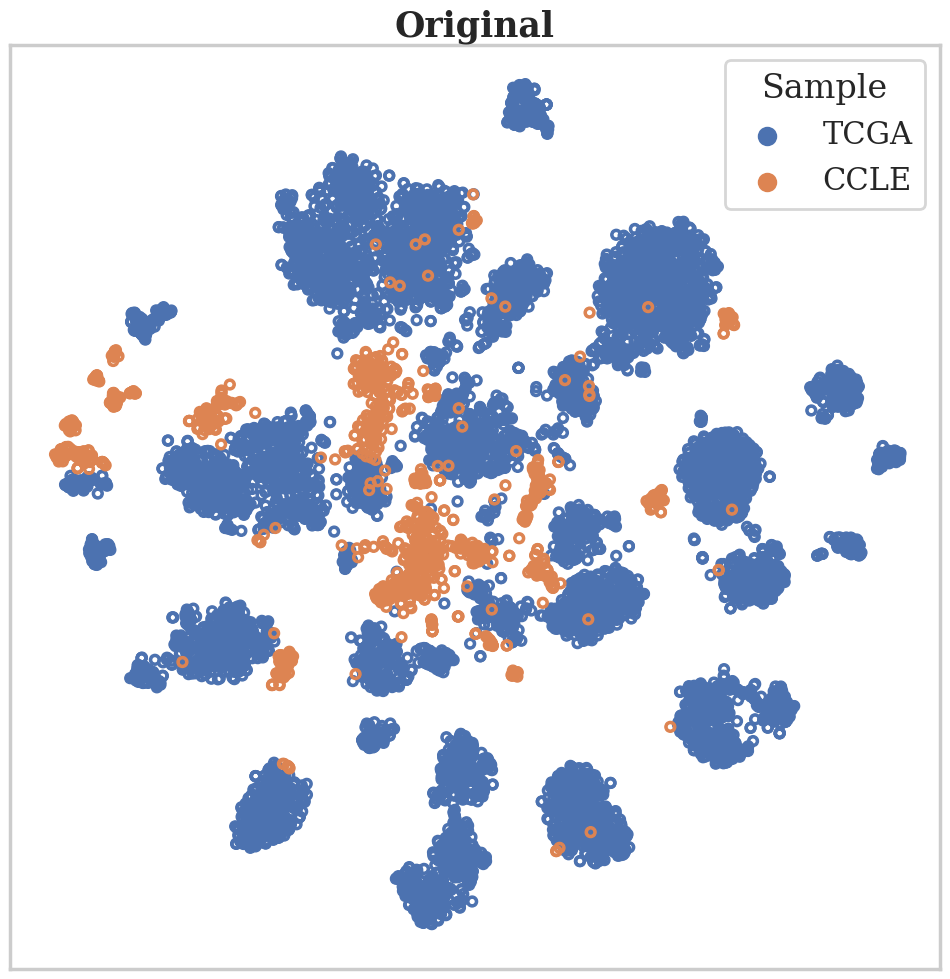

In [11]:
plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [12]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_tcga_features.csv',index_col=0)
ae_all_gex = pd.concat([tcga_gex, ccle_gex])
ae_all_gex_y = tsne.fit_transform(ae_all_gex)


    

FileNotFoundError: [Errno 2] No such file or directory: '../intermediate_results/encoded_features/ae_ccle_features.csv'

In [13]:
ae_encoder_feature_df = pd.DataFrame(ae_all_gex_y, columns=['x','y'])
ae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=ae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/AE_tSNE.png', format='png', dpi=350,bbox_inches='tight')


NameError: name 'ae_all_gex_y' is not defined

In [212]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_tcga_features.csv',index_col=0)
codeae_all_gex = pd.concat([tcga_gex, ccle_gex])
codeae_all_gex_y = tsne.fit_transform(codeae_all_gex)


    

Text(0.5, 1.0, 'AE')

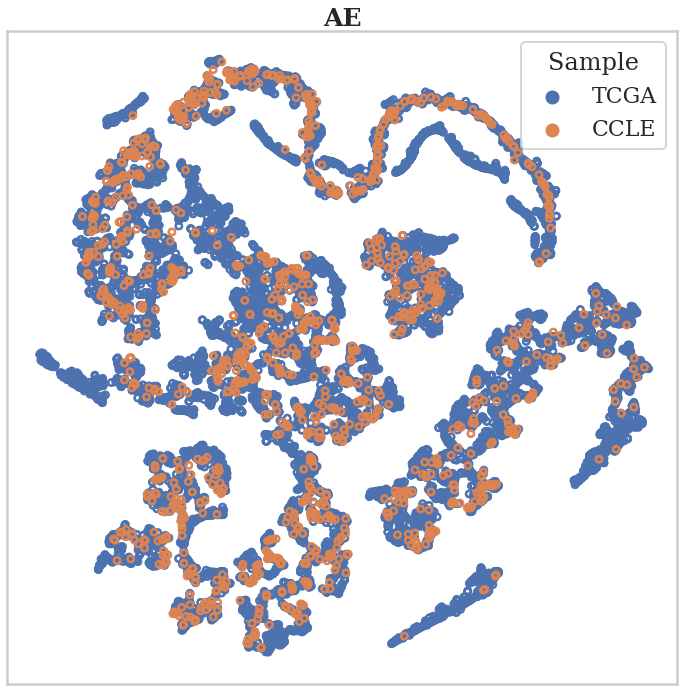

In [213]:
codeae_encoder_feature_df = pd.DataFrame(codeae_all_gex_y, columns=['x','y'])
codeae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=codeae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/CODEAE_tSNE.png', format='png', dpi=350,bbox_inches='tight')
